### HW2 part 4  : Executive summary 

"Match positionally the HLC and NSC catalogs; analyze whether the 
two sets of proper motions are statistically consistent. In particular,
test whether accounting for proper motions decreases positional discrepancies, and whether HLC or NSC pm’s are better in this case.

Hint: need to decide on matching radius, be careful about the faint limit, non-gaussianity, does chi2dof become ~1?…""


In [4]:
# Imports 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
from astropy.io import fits
import pandas as pd

If you already have cross-matched NSC, HLC catalogs, go to [step 2](#step2) 

## 1) Load NSC,  HLC, and crossmatch <a id='toc'></a>

In [2]:
# Load the NSC data ... 
table_neg = Table.read('NSC_stripe82_Dec_negative.csv')
table_pos = Table.read('NSC_stripe82_Dec_positive.csv')

In [3]:
# Stack the two tables vertically 
nsc = vstack([table_neg, table_pos])
print('Done')

Done


In [4]:
# Read in the HLC data : 
catalogs = ['HLC.RA_20_to_21.fits.gz',
'HLC.RA_21_to_22.fits.gz',
'HLC.RA_22_to_23.fits.gz',
'HLC.RA_23_to_24.fits.gz',
'HLC.RA_00_to_01.fits.gz',
'HLC.RA_01_to_02.fits.gz',
'HLC.RA_02_to_03.fits.gz',
'HLC.RA_03_to_04.fits.gz']


def ReadTable(name):
    dir_hlc = '../HW_1/'
    hlc_fits = fits.open(dir_hlc+name)
    hlc_table = Table(hlc_fits[1].data)
    return hlc_table

hlc = ReadTable(catalogs[0])
for catalog in catalogs[1:] : 
    print('Reading ', catalog)
    hlc_cat = ReadTable(catalog)
    hlc = vstack([hlc, hlc_cat])



Reading  HLC.RA_21_to_22.fits.gz
Reading  HLC.RA_22_to_23.fits.gz
Reading  HLC.RA_23_to_24.fits.gz
Reading  HLC.RA_00_to_01.fits.gz
Reading  HLC.RA_01_to_02.fits.gz
Reading  HLC.RA_02_to_03.fits.gz
Reading  HLC.RA_03_to_04.fits.gz


In [5]:
# Since S82 is centered on RA=0 , stretchin roughly +/- 50 degrees away
# it makes sense to change 0-360 to -180 / +180 .. 

coord = 'RA'
for col_type in  ['_MEAN','_MEAN_CLIP']:    
    c =coord+col_type
    hlc[c +'_W'] = np.where(hlc[c]>180, hlc[c]-360, hlc[c])

In [7]:
# Do the same for the   NSC catalog 
nsc['raW'] = np.where(nsc['ra']>180, nsc['ra']-360, nsc['ra'])

(array([ 691534.,  457369.,  347377.,  301786.,  564468.,  278232.,
         260392.,  262289.,  278604.,  258497.]),
 array([ -4.94999888e+01,  -3.95999909e+01,  -2.96999929e+01,
         -1.97999950e+01,  -9.89999700e+00,   9.48565969e-07,
          9.89999890e+00,   1.97999968e+01,   2.96999948e+01,
          3.95999927e+01,   4.94999907e+01]),
 <a list of 1 Patch objects>)

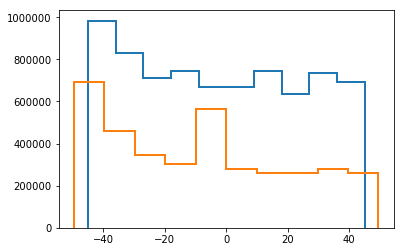

In [8]:
# Show the ra coverage of nsc vs hlc ....
%matplotlib inline
plt.hist(nsc['raW'], histtype='step', lw=2)
plt.hist(hlc['RA_MEAN_CLIP_W'], histtype='step', lw=2)

In [9]:
# To make things faster, we split this range 
# into bins of RA 

ra_col  = 'RA_MEAN_CLIP_W' # choose which ra type to use for HLC 
hlc_nsc = Table()
ra = np.arange(-50,60,10)
for i in range(len(ra)-1):
    print('Matching ra in range ',ra[i], ra[i+1])
    mask_hlc = (ra[i]<hlc[ra_col])*(hlc[ra_col] < ra[i+1])
    mask_nsc = (ra[i]<nsc['raW'])*(nsc['raW'] < ra[i+1])
    
    hlc_sel = hlc[mask_hlc]
    nsc_sel = nsc[mask_nsc]
    
    hlc_coords = SkyCoord(ra=hlc_sel[ra_col]*u.degree, 
                          dec=hlc_sel['DEC_MEAN']*u.degree
                         )
    nsc_coords = SkyCoord(ra = nsc_sel['raW']*u.degree,  
                          dec = nsc_sel['dec']*u.degree
                         )
    
    idx, d2d, d3d = hlc_coords.match_to_catalog_sky(nsc_coords)  
    
    hlc_nsc_sel = hstack([hlc_sel, nsc_sel[idx]], table_names = ['hlc', 'nsc'])
    hlc_nsc_sel['sep_2d_arcsec'] = d2d.arcsec
    
    hlc_nsc = vstack([hlc_nsc_sel, hlc_nsc])
    
print('Finished crossmatching')    

Matching ra in range  -50 -40
Matching ra in range  -40 -30
Matching ra in range  -30 -20
Matching ra in range  -20 -10
Matching ra in range  -10 0
Matching ra in range  0 10
Matching ra in range  10 20
Matching ra in range  20 30
Matching ra in range  30 40
Matching ra in range  40 50


3700548 2765649


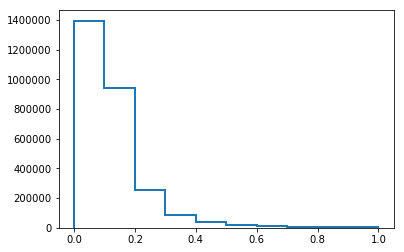

In [11]:
# plot the separation histogram ....
# there is a clean peak close to zero : 
# these are the matched sources 
x = hlc_nsc['sep_2d_arcsec']
plt.hist(x[x<1], histtype='step', lw=2 )

#  select matched sources 
x = hlc_nsc['sep_2d_arcsec']
matched = x < 1 
selected =  hlc_nsc[matched]

# How many of the hlc sources had a good match ? 
print(len(hlc), len(selected))

In [37]:
# Since the above steps take quite a while, save the cross-matched table 
# with good matches ... 

# Check whether the file with cross-matched catalogs exists....
fname =  'hlc_nsc_1arcsec_'+str(len(selected))+'_main'
import os 
if fname not in os.listdir() : 
    print('Saving the cross-matched catalog main columns as ', fname )

    # store in this variable all columns of combined HLC-NSC catalog 
    all_cols = np.ravel(hlc_nsc.colnames)

    # explicitly choose which columns to save in the main cross-matched catalog 
    select_cols = ['LC_NAME', 'IAU_NAME', 'N_GOOD_EPOCHS', 'MEAN_PSFMAG',
           'MEAN_PSFMAG_ERR', 
           'N_GOOD_EPOCHS_PSF_CLIP', 
       'MEAN_PSFMAG_CLIP', 'MEAN_PSFMAG_ERR_CLIP', 
       'TIME_SPAN', 'MEAN_OBJECT_TYPE', 'REDDENING',
       'RA_MEAN_CLIP_W', 'RA_MEAN_ERR_CLIP', 'RA_PM_CLIP', 
       'RA_PM_ERR_CLIP', 'DEC_MEAN_CLIP', 'DEC_MEAN_ERR_CLIP',
       'DEC_PM_CLIP', 'DEC_PM_ERR_CLIP',
     'T0', 'T0_CLIP','N_POS_EPOCHS_CLIP', 'ECL_REDCHISQ_OUT', 'ECL_STAT', 'ECL_EPOCH',
       'ra', 'dec',
       'pmra', 'pmraerr', 'pmdec', 'pmdecerr', 'mjd', 'deltamjd', 'gmag',
       'grms', 'gerr', 'rmag', 'rrms', 'rerr', 'imag', 'irms', 'ierr',
       'class_star', 'fwhm', 'ebv', 'nphot', 'raW', 'sep_2d_arcsec']

    np.save(fname,selected[select_cols])

    # store all other columns in the auxiliary cross-matched catalog 
    other_cols = all_cols[~np.in1d(all_cols,select_cols)]
    fname =  'hlc_nsc_1arcsec_'+str(len(selected))+'_auxiliary'
    print('Saving the cross-matched catalog aux columns as ', fname )
    np.save(fname,selected[list(other_cols)])

    # it can be loaded into AstroPy as  
    #test = Table(np.load(fname))

Saving the cross-matched catalog main columns as  hlc_nsc_1arcsec_2765649_main
Saving the cross-matched catalog aux columns as  hlc_nsc_1arcsec_2765649_auxiliary


## Load the saved NSC-HLC cross-matched catalogs  <a id='step2'></a>

[Go to top](#toc)

In [5]:
fname =  'hlc_nsc_1arcsec_2765649_main'
selected = Table(np.load(fname+'.npy'))

In [9]:
#selected['MEAN_PSFMAG']

In [10]:
# extract the magnitudes
def FormatMagnitude(table):
    mean_psfmag = Table(table['MEAN_PSFMAG'], names=('u', 'g', 'r', 'i','z'))
    mean_psfmag_err = Table(table['MEAN_PSFMAG_ERR'], names=('u', 'g', 'r', 'i','z'))
    SN = {} #a dictionary
    for f in mean_psfmag.colnames : 
        SN[f] = mean_psfmag[f] / mean_psfmag_err[f]
    return mean_psfmag, mean_psfmag_err, SN

mean_psfmag, mean_psfmag_err, SN = FormatMagnitude(selected)

# select only high signal to noise :
mSN = (SN['g'] > 5) * ( SN['r'] > 5) * ( SN['i'] > 5 )
m_r = mean_psfmag['r'].data > 10.0

dra = 3600*(selected['RA_MEAN_CLIP_W'] - selected['raW']) 
ddec = 3600*(selected['DEC_MEAN_CLIP'] - selected['dec'])

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


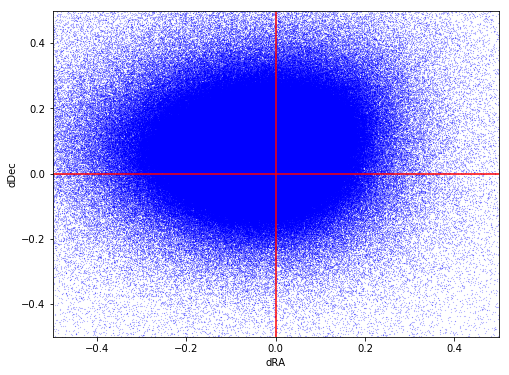

-0.0290098294954
0.112137273124
0.0527220436904
0.105958171946
-0.997980945218
0.99929900412


In [11]:
# Quality assessment  : 
%matplotlib inline 
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(dra, ddec, s=0.01, c='blue')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)
ax.set_xlabel('dRA')
ax.set_ylabel('dDec')
ax.plot([-0.5,0.5], [0.0, 0.0], '-k', c='red')
ax.plot([0,0], [-0.5, 0.5], '-k', c='red')
plt.show()
print(np.median(dra))
print(np.std(dra))
print(np.median(ddec))
print(np.std(ddec))
print(np.min(dra))
print(np.max(dra))

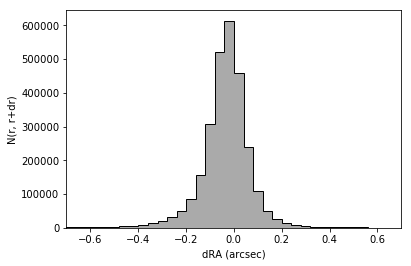

-0.0290098294954


In [12]:
from astroML.plotting import hist
ax = plt.axes()
plt.hist(dra.data.data, bins=50, histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('dRA (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.set_xlim(-0.7, 0.7)
plt.show()
print(np.median(dra))

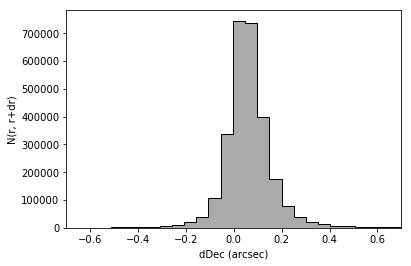

0.0527220436904


In [13]:
from astroML.plotting import hist
ax = plt.axes()
plt.hist(ddec.data.data, bins=50, histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('dDec (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.set_xlim(-0.7, 0.7)
plt.show()
print(np.median(ddec))

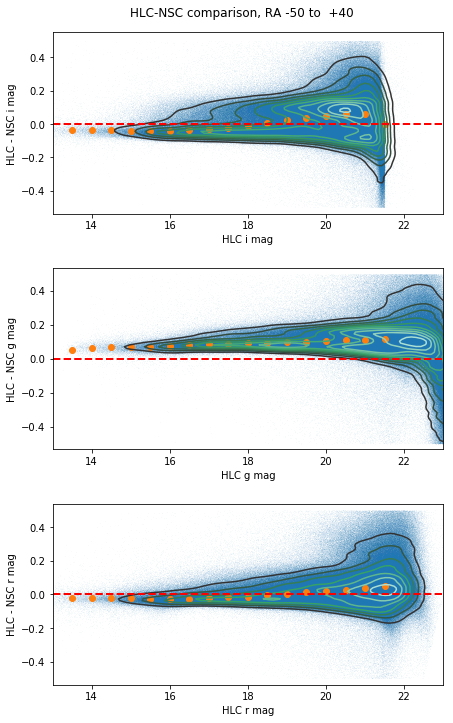

In [48]:
from scipy.stats import binned_statistic as bs 
import seaborn as sns
# plot mgnitude comparison ....

# select stars
m_star = selected['class_star'] > 0.5 
m = mSN * m_r * m_star

%matplotlib inline
fig,ax = plt.subplots(3,1, figsize=(7,12))
i = 0 
bins  =  np.arange(13,22, 0.5)
for c in 'igr' : 
    mag1 = mean_psfmag[c][m]
    mag2 = selected[c+'mag'][m] 
    dmag  = mag1 - mag2
    m1 = np.abs(dmag) < 0.5  # select matches within 0.5 mag 
    m2 = mag1>10 # and remove all points which do not have the proper mag info 
    mask = m1*m2 
    
    x,y = mag1[mask] , dmag[mask]
    
    stats = bs(x,y,statistic='median', bins=bins)
    
    ax[i].scatter(x,y, s=0.0001 )
    
    # add contours subsampled by a 
    # factor of 50 ... 
    sns.kdeplot(x[::50],y[::50], ax=ax[i])
    
    ax[i].set_xlabel('HLC '+c+' mag')
    ax[i].set_ylabel('HLC - NSC '+c+ ' mag')
    ax[i].scatter(bins[1:], stats.statistic)
    ax[i].set_xlim(13,23)
    ax[i].axhline(0,lw=2,ls='--', c='red')
    i += 1 
fig.subplots_adjust(hspace=0.3)
fig.suptitle('HLC-NSC comparison, RA -50 to  +40',y=0.91)
plt.savefig('hlc_vs_nsc_mags_S82_stars.png', bbox_inches='tight')

### Using time difference between catalog epochs to correct RA,DEC accounting for PM 

In [253]:
m_star = selected['class_star'] > 0.5 
m_sn = (mean_psfmag['g'] / mean_psfmag_err['g'])> 5
#m_mag = mean_psfmag['r'] < 20 
m = m_sn * m_star

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


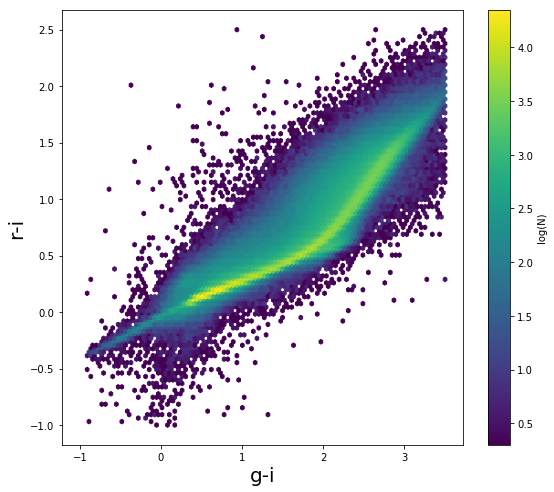

In [243]:
# plot g-i vs r-i  plot for selection ...

col0 = mean_psfmag['g'][m] - mean_psfmag['i'][m]
col1 = mean_psfmag['r'][m] - mean_psfmag['i'][m]

# 2D-histogram of objects in the g-r vs r-i color diagram 
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 3.5, -1,2.5))
#ax1.axis([-0.2, 2.0, 23.5, 14])
ax1.set_xlabel('g-i',fontsize=20)
ax1.set_ylabel('r-i',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

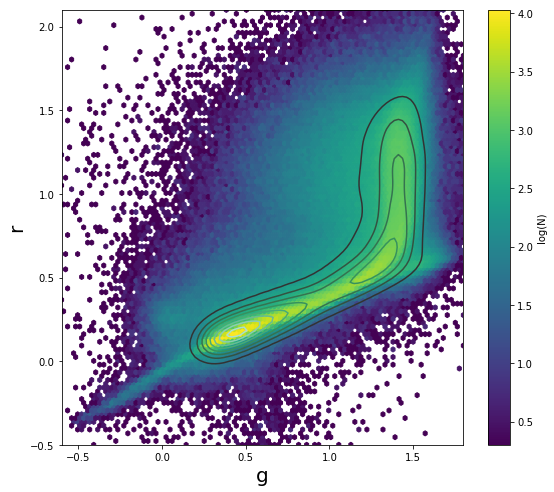

In [254]:
# plot g-r vs r-i  plot for selection ...

col0 = mean_psfmag['g'][m] - mean_psfmag['r'][m]
col1 = mean_psfmag['r'][m] - mean_psfmag['i'][m]

xmin,xmax = -0.6, 1.8
ymin,ymax = -0.5, 2.1
# 2D-histogram of objects in the g-r vs r-i color diagram 
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin,xmax,ymin,ymax))
#ax1.axis([-0.2, 2.0, 23.5, 14])
ax1.set_xlabel('g-r',fontsize=20)
ax1.set_ylabel('r-i',fontsize=20)

sns.kdeplot(col0[::30],col1[::30], ax=ax1, clip = ((xmin,xmax),(ymin,ymax) ))

#color bar
cb = plt.colorbar(im1,label='log(N)')

The two catalogs observe the same sources at different times. Thus the ra,dec positions in two catalogs are recording positions of stars at two epochs.  Plot the histogram of time difference between the two epochs : 

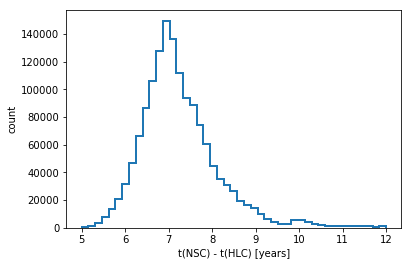

In [289]:
# plot the distribution of time differences
plt.hist((dt.jd) / 365,  lw=2, histtype='step', bins=45, range=[5,12])
plt.xlabel('t(NSC) - t(HLC) [years]',)
plt.ylabel('count')

In [280]:
import seaborn as sns


# A function to calculate the ra,dec correction
# based on proper motions, 
# and investigate color and magnitude dependence 

def plot_dra_ddec(selected, m, fig_name):
    # call  '1'  NSC ,   '2' :  HLC 
    t1 = selected['mjd'][m]  # this is in MJD 

    # starts with degrees , convert to miliarcseconds 
    degrees_to_miliarcsec =  3600 * 1000
    ra1 = selected['raW'][m]  * degrees_to_miliarcsec 
    dec1 = selected['dec'][m] * degrees_to_miliarcsec 

    # starts with miliarcsec / year 
    pmra1 = selected['pmra'][m]
    pmdec1 = selected['pmdec'][m]

    # since we are using clipped values,  let's use T0_CLIP : 
    # this is the beginning of the HLC light curve.  
    # Now, TIME_SPAN is the length of the light curve,
    # so probably the best would be to use 
    # the middle of the light curve : 
    t2  = selected['T0_CLIP'][m]+selected['TIME_SPAN'][m]/2.0  # this is in JD !  

    # start with degrees , convert to miliarcsec
    ra2 = selected['RA_MEAN_CLIP_W'][m] * degrees_to_miliarcsec 
    dec2 = selected['DEC_MEAN_CLIP'][m] * degrees_to_miliarcsec 

    # start with arcsec / year 
    pmra2 = 1000*selected['RA_PM_CLIP'][m] # convert to miliarcsec from arcsec... 
    pmdec2= 1000*selected['DEC_PM_CLIP'][m]
    
    # calculate the time difference as an AstroPy object 
    t1_ =  Time(t1, format='mjd')
    t2_ =  Time(t2, format='jd')

    # t1 > t2,  because NSC has later dates than HLC. 
    # thus the difference is > 0 
    dt = t1_ - t2_  
    
    # convert the difference from days to years 
    dt_years = (t1_.mjd - t2_.mjd) / 365
    
    # plot uncorrected dra vs ddec 
    dra = ra2 - ra1
    ddec = dec2 - dec1

    # thus corrected ra,dec would be in miliarcsec : 
    dracorr1 = pmra1 * dt_years
    ddeccorr1 = pmdec1 * dt_years

    dracorr2 = pmra2 * dt_years
    ddeccorr2 = pmdec2 * dt_years
    
    # plotting  : initialize the figure 
    fig,ax = plt.subplots(1,3, figsize=(13.8,4))
    
    # same setup for all subplots 
    dotsize= 0.0001
    ramax = 200 # miliarcsec
    xmin,xmax = -ramax, ramax
    ymin,ymax = -ramax, ramax 
    for x,y,title,i in zip([dra,dracorr1,dracorr2],
                          [ddec, ddeccorr1, ddeccorr2],
                          ['uncorrected', 'using NSC PM',
                          'using HLC PM'],
                          [0,1,2]
                          ) :
        # first, plot uncorrected dra = ra2 - ra1 ... 
        ax[i].set_title(title)
        ax[i].scatter(x,y, s=dotsize)
        # overplot the contours ...
        #sns.kdeplot(x[::30], y[::30], ax=ax[i], 
        #            clip = ((xmin,xmax),(ymin,ymax) ))
        
        ax[i].set_xlim(xmin,xmax)
        ax[i].set_ylim(ymin,ymax)
        ax[i].set_xlabel('dRA [miliarcsec]')
        ax[i].set_ylabel('dDec [miliarcsec]')
        ax[i].axhline(0, c='red')
        ax[i].axvline(0, c='red')
        x0 = -150
        ax[i].text(x0,-100,'med(x)='+str(np.median(x))[:5])
        ax[i].text(x0,-125,'med(y)='+str(np.median(y))[:5])
        ax[i].text(x0,-150, r'$\sigma_{G}(x)=$'+str(sigmaG(x))[:5])
        ax[i].text(x0,-175, r'$\sigma_{G}(y)=$'+str(sigmaG(y))[:5])
        
        #ax[i].text('median(y)'+str(np.median(x)))
        #
        #ax[i].text(r'$\sigma_{G}(y)=$'+str(sigmaG(y)))
    # then, plot corrected dra  using NSC PM (pmra1 , pmdec1 )
    # ra2 = ra1 + dt * pmra1
    # ra1ra2 - ra1 = dt * pmra1

    #ax[1].set_title('using NSC PM')
    #ax[1].scatter(dracorr1 , ddeccorr1, s=dotsize)
    #sns.kdeplot(dracorr1,ddeccorr1, ax=ax[1])
    
    # then, plot corrected dra  using HLC PM (pmra2 , pmdec2 )
    #ax[2].set_title('using HLC PM')
    #ax[2].scatter(dracorr2 , ddeccorr2, s=dotsize)
    #sns.kdeplot(dracorr2,ddeccorr2, ax=ax[2])

    fig.subplots_adjust(wspace=0.3)
    fig.suptitle(fig_name)
    plt.savefig('hw2_4_NSC_HLC_dra_ddec_'+fig_name+'.png', bbox_inches='tight')
    

blue bright
233996


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


blue faint
212294
red bright
314929
red faint
691540


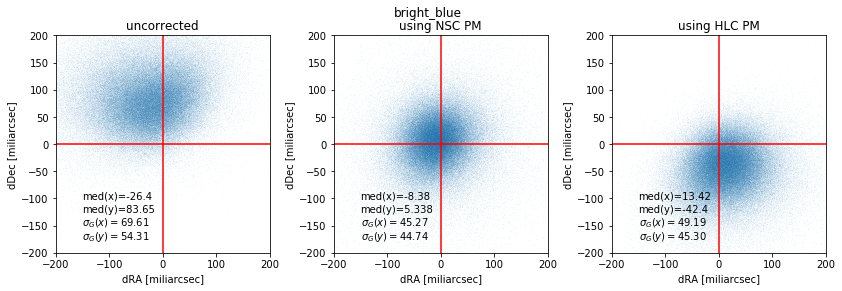

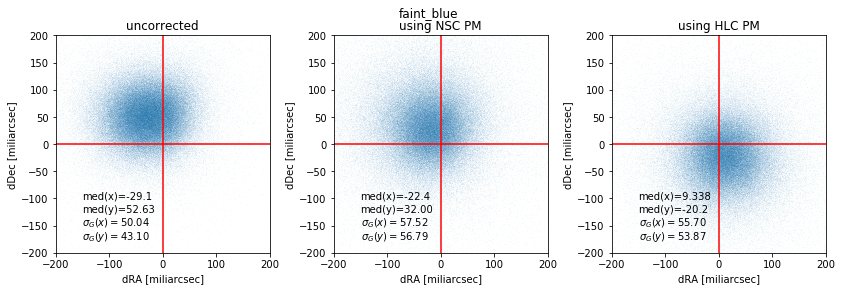

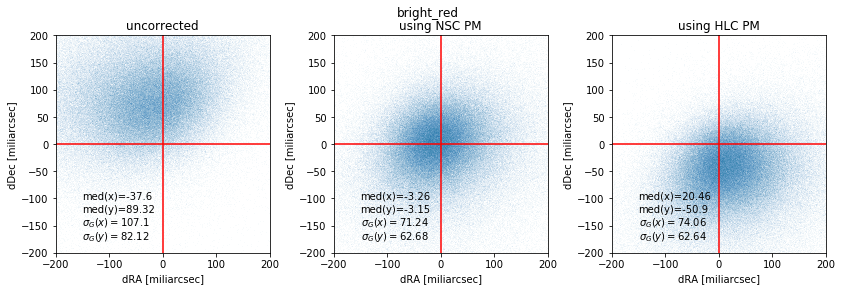

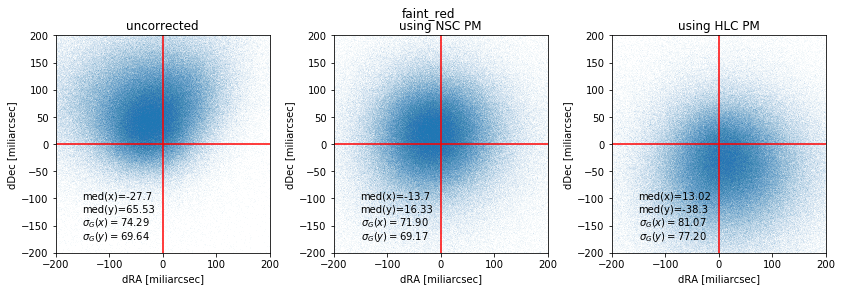

In [281]:
from itertools import product 
from astropy.time import Time
from astroML.stats import sigmaG
# Select by g-i : 
 
# blue   -1 <  g-i < 1  
# red    1  < g-i < 3

# select by magnitude :
# bright   r < 20 
# faint   r >20 

gi_color_cuts = {'blue': [-1,1], 'red':[1,3]}
magnitude_cuts = ['bright', 'faint']
for gi_cut, mag_cut in product(gi_color_cuts.keys(), magnitude_cuts):
    print(gi_cut, mag_cut)
    gi_min, gi_max = gi_color_cuts[gi_cut]
    m_star = selected['class_star'] > 0.5 
    m_sn = (mean_psfmag['g'] / mean_psfmag_err['g'])> 5
    
    gi = mean_psfmag['g'] - mean_psfmag['i']
    m_color = (gi_min < gi)*(gi < gi_max)

    if mag_cut is 'faint':
        m_mag = mean_psfmag['r'] > 20 
    if mag_cut is 'bright':
        m_mag = mean_psfmag['r'] < 20 
        
    m = m_sn * m_star * m_color * m_mag 
    print(np.sum(m))
    
    fig_name = mag_cut+'_'+gi_cut
    plot_dra_ddec(selected, m, fig_name)

In [ ]:
# We've already plotted dRA, dDec above. Time to use the proper motion correction

RA_cat1 = RA_cat2 + PM_RA_cat2 * dt(cat2-cat1)